In [1]:
import numpy as np

with open("g7.td") as f:
    for i, line in enumerate(f):
        if line.strip() == "#DATA":
            start = i + 1
            break

data = np.loadtxt("g7.td", skiprows=start)
print(data[:5])
print(data[-5:])

# time [s]
# Intensity Floureszenz

print(data.shape)

[[ 0.2      94.535   ]
 [ 0.4      94.264333]
 [ 0.6      94.262666]
 [ 0.8      94.379666]
 [ 1.       94.208666]]
[[5399.4       172.133   ]
 [5399.6       171.97    ]
 [5399.8       171.989   ]
 [5400.        172.068333]
 [5400.2       172.376   ]]
(27001, 2)


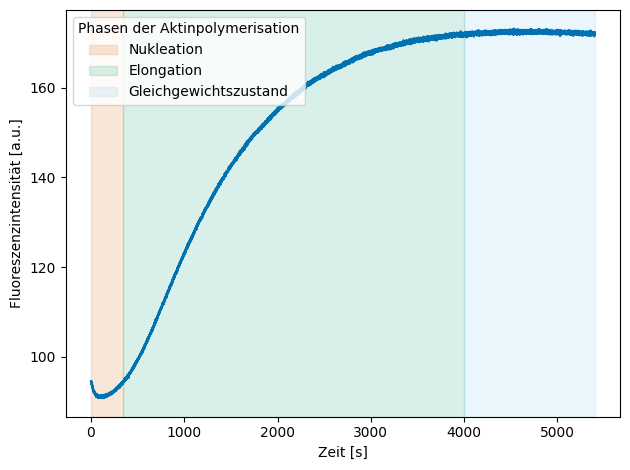

In [2]:
import matplotlib.pyplot as plt

x = data[:, 0]
y = data[:, 1]

plt.figure()
plt.plot(x, y, color="#0072B2", label="Messdaten")

# ---- FARBBEREICHE ----
lag = plt.axvspan(0, 343, color='#D55E00', alpha=0.15, label="Nukleation")
exp = plt.axvspan(343, 4000, color='#009E73', alpha=0.15, label="Elongation")
plateau = plt.axvspan(4000, 5400, color='#56B4E9', alpha=0.12, label="Gleichgewichtszustand")

# ---- ACHSEN ----
plt.xlabel("Zeit [s]")
plt.ylabel("Fluoreszenzintensität [a.u.]")

# ---- LEGENDE ----
plt.legend(handles=[lag, exp, plateau], loc="upper left", title="Phasen der Aktinpolymerisation")

plt.tight_layout()
plt.show()

#"Exponentielle Phase, Sättigungphase

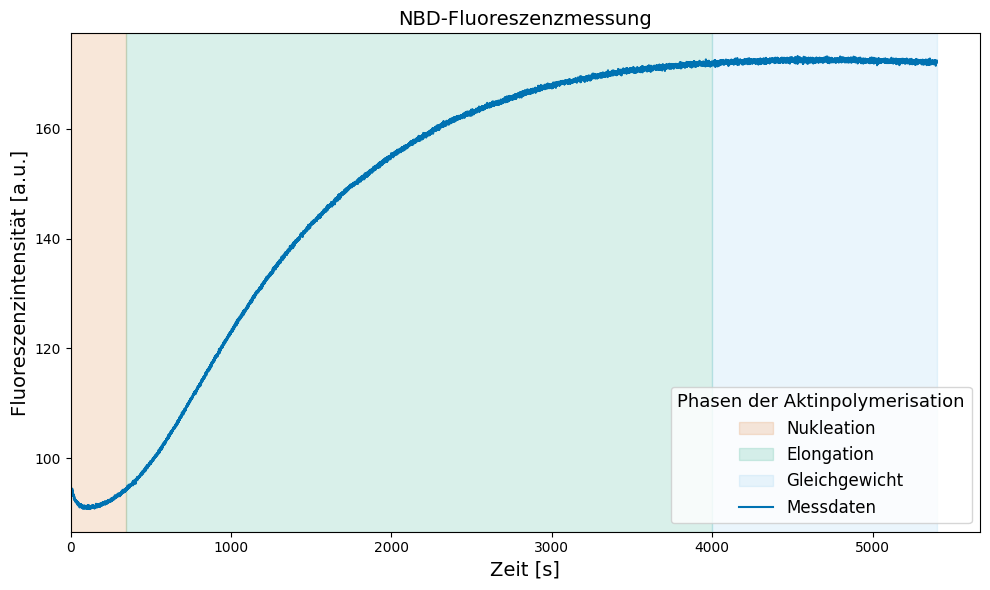

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Daten einlesen
# -------------------------------------------------
with open("g7.td") as f:
    for i, line in enumerate(f):
        if line.strip() == "#DATA":
            start = i + 1
            break

data = np.loadtxt("g7.td", skiprows=start)
x = data[:, 0]   # Zeit [s]
y = data[:, 1]   # Fluoreszenz [a.u.]

# -------------------------------------------------
# Plotting-Vorlage (ohne Fit)
# -------------------------------------------------
plt.figure(figsize=(10, 6))

# Phasen
lag = plt.axvspan(0, 343,  color='#D55E00', alpha=0.15, label="Nukleation")
exp = plt.axvspan(343, 4000, color='#009E73', alpha=0.15, label="Elongation")
plateau = plt.axvspan(4000, 5400, color='#56B4E9', alpha=0.12, label="Gleichgewicht")

# Messdaten
plt.plot(x, y, color="#0072B2", label="Messdaten")

# Titel + Achsen (wie gewünscht)
plt.title("NBD-Fluoreszenzmessung", fontsize=14)
plt.xlabel("Zeit [s]", fontsize=14)
plt.ylabel("Fluoreszenzintensität [a.u.]", fontsize=14)

# X bei 0 starten + weißer Überhang weg
plt.xlim(left=0)
plt.margins(x=0)  # entfernt extra Rand links/rechts

# Legende: wie bisher, nur Phasen + Messdaten
handles = [lag, exp, plateau]
labels = ["Nukleation", "Elongation", "Gleichgewicht"]

# "Messdaten" zusätzlich in die Legende aufnehmen
line_handle = plt.gca().lines[0]
handles.append(line_handle)
labels.append("Messdaten")

plt.legend(
    handles=handles,
    labels=labels,
    loc="lower right",
    fontsize=12,
    title="Phasen der Aktinpolymerisation",
    title_fontsize=13,
    frameon=True
)

plt.tight_layout()
plt.show()


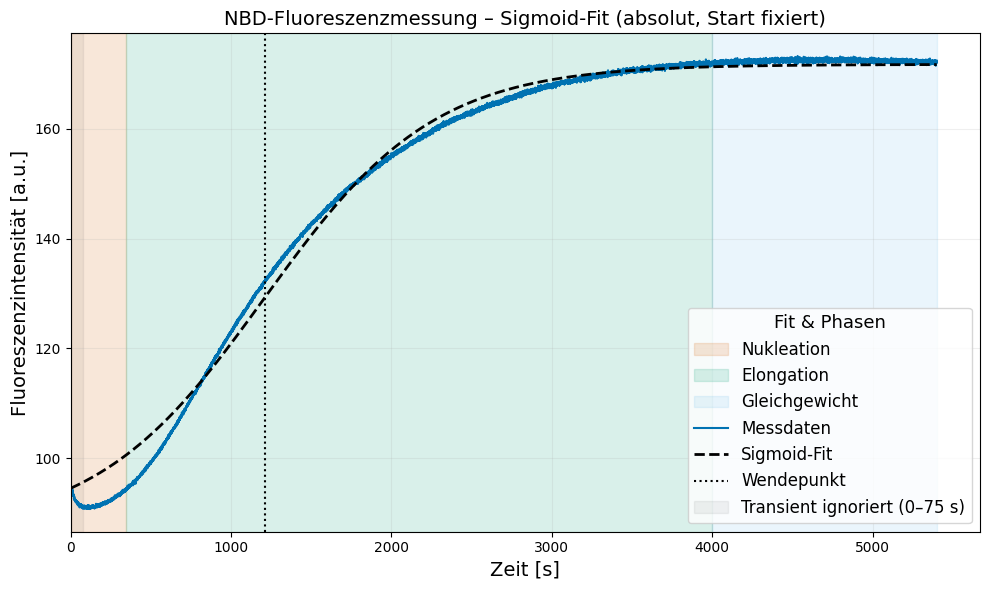


---- Start-Fixierung ----
y0 (fix) = 94.5350 a.u.  (Fit erzwingt y(0)=y0)

---- Sigmoid-Parameter (absoluter Fit, Start fix) ----
K   = 85.010548 a.u.   (Zunahme bis Plateau)
k   = 0.001890 1/s
t0  = 1208.87 s      (Sigmoid-Inflektionsparameter)

---- Wendepunkt (robust: max dI/dt im Elongationsfenster) ----
t*  = 1208.78 s
max dI/dt = 0.040174 a.u./s
R² (Fitbereich, t>=75s) = 0.9928


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -------------------------------------------------
# Daten einlesen
# -------------------------------------------------
with open("g7.td") as f:
    for i, line in enumerate(f):
        if line.strip() == "#DATA":
            start = i + 1
            break

data = np.loadtxt("g7.td", skiprows=start)
x = data[:, 0].astype(float)   # Zeit [s]
y = data[:, 1].astype(float)   # Fluoreszenz [a.u.]

# -------------------------------------------------
# Modell: gewöhnliches Sigmoid, aber START festgenagelt:
# y(0) = y0 (Messwert am Start)
#
# Wir fitten ABSOLUTE Intensität y(t), ohne Baseline-Korrektur.
# Der Trick ist: wir fitten nur die Zunahme Δy(t) als "start0"-Sigmoid
# und addieren den festen Startwert y0 dazu.
# -------------------------------------------------
def sigmoid_start0(t, K, k, t0):
    # Δy(0) = 0 durch den zweiten Term
    return (K / (1.0 + np.exp(-k * (t - t0)))
            - K / (1.0 + np.exp(k * t0)))

def model_abs_startfixed(t, K, k, t0, y0_fixed):
    return y0_fixed + sigmoid_start0(t, K, k, t0)

def fit_sigmoid_absolute_start_fixed(
    x, y,
    t_ignore=75.0,                 # Transient ignorieren bis ~75 s
    t_low_elong=343.0, t_high_elong=4000.0,
    title="NBD-Fluoreszenzmessung – Sigmoid-Fit (absolut, Start fix)"
):
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    # Startwert festlegen (Fit soll da "zwangsläufig" starten)
    y0_fixed = float(y[np.argmin(np.abs(x - 0.0))])

    # Fit-Bereich (Transient ignorieren)
    fit_mask = x >= t_ignore
    xf = x[fit_mask]
    yf = y[fit_mask]

    # Optional: Downsampling für Speed/Stabilität bei 27k Punkten
    step = max(1, len(xf) // 6000)  # ~<=6000 Punkte
    xf = xf[::step]
    yf = yf[::step]

    # -------------------------------------------------
    # Startwerte für (K, k, t0)
    # K ~ Plateau - Start
    # t0 ~ wo etwa die Hälfte erreicht wird (grob)
    # -------------------------------------------------
    K0 = float(np.max(yf) - y0_fixed)
    K0 = max(K0, 1e-6)

    half = y0_fixed + 0.5 * K0
    t0_0 = float(xf[np.argmin(np.abs(yf - half))])
    k0 = 0.003  # 1/s (passt typischerweise bei Minuten-Skala)
    p0 = [K0, k0, t0_0]

    # Bounds (stabil)
    # K >= 0, k > 0, t0 im Messbereich
    lower = [0.0, 0.0, 0.0]
    upper = [np.inf, 1.0, x.max()]

    # Fit: nur 3 Parameter, y0 ist fix
    def f_for_fit(t, K, k, t0):
        return model_abs_startfixed(t, K, k, t0, y0_fixed)

    params, cov = curve_fit(
        f_for_fit,
        xf, yf,
        p0=p0,
        bounds=(lower, upper),
        maxfev=80000
    )

    K_fit, k_fit, t0_fit = params

    # Fitkurve für komplette Zeit
    t_plot = np.linspace(0, x.max(), 1200)
    y_fit_plot = f_for_fit(t_plot, *params)
    y_fit_all = f_for_fit(x, *params)

    # Wendepunkt & Steigung (für diese Form gilt: Wendepunkt = t0)
    t_star = float(t0_fit)
    slope_star = float(K_fit * k_fit / 4.0)  # a.u./s (Ableitung der Δy, y0 ist konstant)

    # Alternativ robust über numerische Ableitung im Elongationsfenster:
    # (falls du t0 nicht als Wendepunkt setzen willst)
    t_grid = np.linspace(x.min(), x.max(), 20000)
    y_grid = f_for_fit(t_grid, *params)
    dy_dt = np.gradient(y_grid, t_grid)
    mask = (t_grid >= t_low_elong) & (t_grid <= t_high_elong)
    idx = np.argmax(dy_dt[mask])
    t_inflection = float(t_grid[mask][idx])
    slope_sec = float(dy_dt[mask][idx])  # a.u./s

    # R² auf Fitbereich (fair)
    y_pred_fit = f_for_fit(xf, *params)
    ss_res = np.sum((yf - y_pred_fit) ** 2)
    ss_tot = np.sum((yf - np.mean(yf)) ** 2)
    R2 = 1 - ss_res / ss_tot

    # -------------------------------------------------
    # Plot (deine Vorlage + Fit), absolute Intensität
    # -------------------------------------------------
    plt.figure(figsize=(10, 6))

    lag = plt.axvspan(0, 343,   color='#D55E00', alpha=0.15, label="Nukleation")
    exp = plt.axvspan(343, 4000, color='#009E73', alpha=0.15, label="Elongation")
    plateau = plt.axvspan(4000, 5400, color='#56B4E9', alpha=0.12, label="Gleichgewicht")

    plt.plot(x, y, color="#0072B2", label="Messdaten")
    plt.plot(
        t_plot, y_fit_plot, "k--", linewidth=2,
        label=(
            "Fit: Sigmoid (Start fix)\n"
            f"Steigung@Wendepunkt: {slope_sec:.4f} a.u./s\n"
            f"R² (Fitbereich): {R2:.4f}"
        )
    )

    plt.axvline(t_inflection, color="k", linestyle=":", label=f"Wendepunkt = {t_inflection:.0f} s")

    # Transient-Bereich markieren (ignoriert im Fit)
    transient_patch = plt.axvspan(0, t_ignore, color="k", alpha=0.05,
                                  label=f"Transient ignoriert (0–{t_ignore:.0f} s)")

    plt.title(title, fontsize=14)
    plt.xlabel("Zeit [s]", fontsize=14)
    plt.ylabel("Fluoreszenzintensität [a.u.]", fontsize=14)

    # x ab 0, ohne weißen Überhang
    plt.xlim(left=0)
    plt.margins(x=0)

    # Legende: wie gehabt, sauber sortiert
    ax = plt.gca()
    line_data = ax.lines[0]
    line_fit  = ax.lines[1]
    vline      = ax.lines[2]

    handles = [lag, exp, plateau, line_data, line_fit, vline, transient_patch]
    labels  = ["Nukleation", "Elongation", "Gleichgewicht",
               "Messdaten", "Sigmoid-Fit", "Wendepunkt", f"Transient ignoriert (0–{t_ignore:.0f} s)"]

    plt.legend(
        handles=handles,
        labels=labels,
        loc="lower right",
        fontsize=12,
        title="Fit & Phasen",
        title_fontsize=13,
        frameon=True
    )

    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

    # Ausgabe
    print("\n---- Start-Fixierung ----")
    print(f"y0 (fix) = {y0_fixed:.4f} a.u.  (Fit erzwingt y(0)=y0)")

    print("\n---- Sigmoid-Parameter (absoluter Fit, Start fix) ----")
    print(f"K   = {K_fit:.6f} a.u.   (Zunahme bis Plateau)")
    print(f"k   = {k_fit:.6f} 1/s")
    print(f"t0  = {t0_fit:.2f} s      (Sigmoid-Inflektionsparameter)")
    print("\n---- Wendepunkt (robust: max dI/dt im Elongationsfenster) ----")
    print(f"t*  = {t_inflection:.2f} s")
    print(f"max dI/dt = {slope_sec:.6f} a.u./s")
    print(f"R² (Fitbereich, t>={t_ignore:.0f}s) = {R2:.4f}")

    return params, cov, {"y0_fixed": y0_fixed, "t_star": t_inflection, "slope_au_per_s": slope_sec, "R2_fit": R2}

# -------------------------------------------------
# AUFRUF
# -------------------------------------------------
params, cov, info = fit_sigmoid_absolute_start_fixed(
    x, y,
    t_ignore=75,
    title="NBD-Fluoreszenzmessung – Sigmoid-Fit (absolut, Start fixiert)"
)


# New try

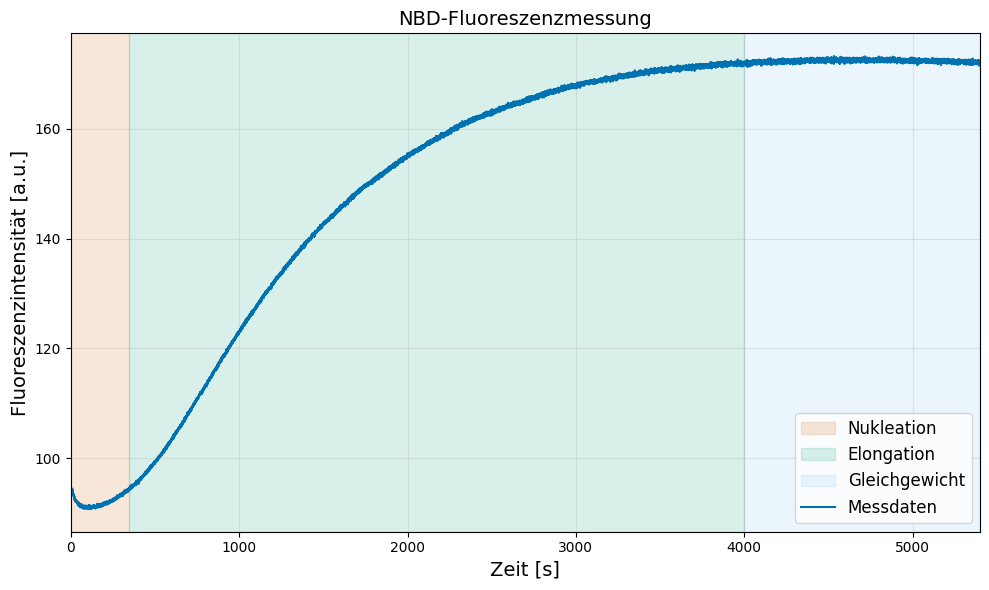

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.axvspan(0, 343, color="#D55E00", alpha=0.15, label="Nukleation")
plt.axvspan(343, 4000, color="#009E73", alpha=0.15, label="Elongation")
plt.axvspan(4000, 5400, color="#56B4E9", alpha=0.12, label="Gleichgewicht")

plt.plot(x, y, color="#0072B2", label="Messdaten")

plt.xlim(0, x.max()) # <- kein weißer Rand mehr links

plt.title("NBD-Fluoreszenzmessung", fontsize=14)
plt.xlabel("Zeit [s]", fontsize=14)
plt.ylabel("Fluoreszenzintensität [a.u.]", fontsize=14)

plt.legend(loc="lower right", fontsize=12, frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Mittelwerte und Standardabweichungen in den Plateau-Bereichen berechnen
import numpy as np

# Zeitfenster
tN0, tN1 = 0, 343
tE0, tE1 = 4000, 5400

# Masken
mask_nuc = (x >= tN0) & (x <= tN1)
mask_eq  = (x >= tE0) & (x <= min(tE1, x.max()))

# Plateau-Werte
nuc_mean = np.mean(y[mask_nuc])
nuc_std  = np.std(y[mask_nuc], ddof=1)

eq_mean  = np.mean(y[mask_eq])
eq_std   = np.std(y[mask_eq], ddof=1)

print(f"Nukleations-Plateau ({tN0}-{tN1} s): {nuc_mean:.3f} ± {nuc_std:.3f} a.u. (n={mask_nuc.sum()})")
print(f"Gleichgewichts-Plateau ({tE0}-{min(tE1, x.max()):.0f} s): {eq_mean:.3f} ± {eq_std:.3f} a.u. (n={mask_eq.sum()})")


Nukleations-Plateau (0-343 s): 92.140 ± 1.010 a.u. (n=1715)
Gleichgewichts-Plateau (4000-5400 s): 172.312 ± 0.254 a.u. (n=7001)


In [21]:
delta_plateau = eq_mean - nuc_mean

print(f"ΔPlateau = {delta_plateau:.3f} a.u.")


ΔPlateau = 80.173 a.u.


In [22]:
delta_std = np.sqrt(nuc_std**2 + eq_std**2)
print(f"ΔPlateau = {delta_plateau:.3f} ± {delta_std:.3f} a.u.")


ΔPlateau = 80.173 ± 1.042 a.u.


In [59]:
import numpy as np
from scipy.optimize import curve_fit

# Sigmoid mit y(0)=nuc_mean garantiert
def sigmoid_y0(t, K, r, t0):
    S  = 1 / (1 + np.exp(-r * (t - t0)))
    S0 = 1 / (1 + np.exp(-r * (0 - t0)))   # Wert bei t=0
    return nuc_mean + K * (S - S0)

# Fit-Fenster (Elongation)
t_low, t_high = 200, x.max()
# t_low, t_high = 343, 4000
mask_fit = (x >= t_low) & (x <= t_high)
x_fit = x[mask_fit]
y_fitdata = y[mask_fit]

# Startwerte
K0  = eq_mean - nuc_mean
r0  = 0.002
t0_0 = 1200.0
p0 = [K0, r0, t0_0]

# Bounds
bounds_lower = [0.0, 0.0, 0.0]
bounds_upper = [np.inf, 1.0, x.max()]

params, cov = curve_fit(
    sigmoid_y0, x_fit, y_fitdata,
    p0=p0,
    bounds=(bounds_lower, bounds_upper),
    maxfev=200000
)

K_s, r_s, t0_s = params
y_sig = sigmoid_y0(x, *params)


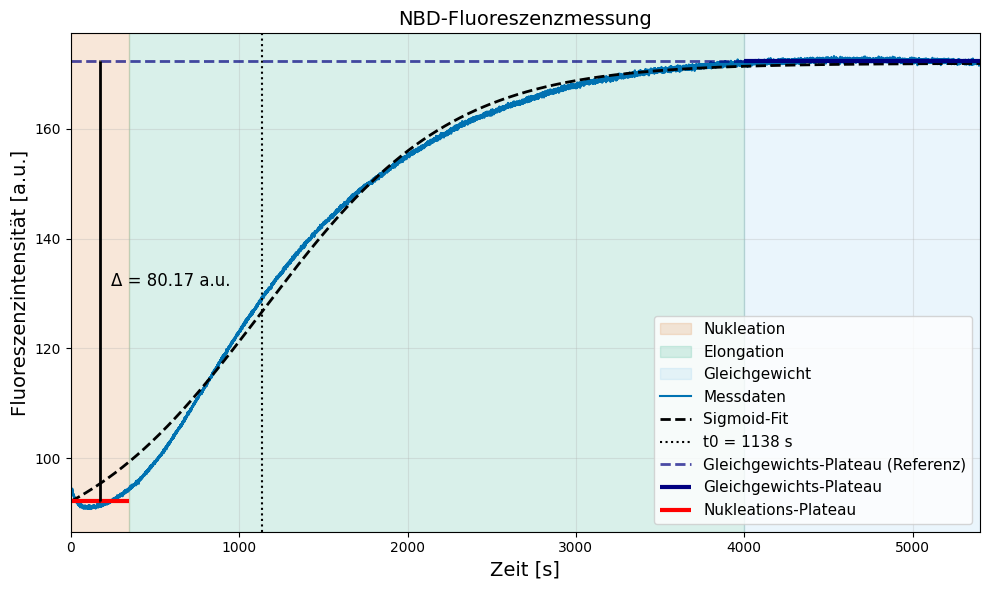

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Phasen
plt.axvspan(0, 343, color="#D55E00", alpha=0.15, label="Nukleation")
plt.axvspan(343, 4000, color="#009E73", alpha=0.15, label="Elongation")
plt.axvspan(4000, 5400, color="#56B4E9", alpha=0.12, label="Gleichgewicht")

# Messdaten
plt.plot(x, y, color="#0072B2", label="Messdaten")
mask_plot = x >= 0
plt.plot(x[mask_plot], y_sig[mask_plot], "k--", linewidth=2, label="Sigmoid-Fit")
plt.axvline(t0_s, color="k", linestyle=":", linewidth=1.5, label=f"t0 = {t0_s:.0f} s")

# Plateau-Linien
# Plateau-Linien (farbig + durchgezogen)
# Gleichgewichts-Plateau: gestrichelt über ganzen Plot (Referenz)
plt.hlines(
    eq_mean,
    xmin=0,
    xmax=x.max(),
    colors="navy",
    linestyles="--",
    linewidth=2,
    alpha=0.7,
    label="Gleichgewichts-Plateau (Referenz)"
)

# Gleichgewichts-Plateau: durchgezogen im eigentlichen Bereich
plt.hlines(
    eq_mean,
    xmin=4000,
    xmax=x.max(),
    colors="navy",
    linewidth=3,
    label="Gleichgewichts-Plateau"
)
plt.hlines(nuc_mean, xmin=0, xmax=343, colors="red", linewidth=3, label="Nukleations-Plateau")


# Delta-Klammer
x_bracket = 0.5 * (0 + 343)   # Mitte des Nukleationsfensters
plt.vlines(x_bracket, nuc_mean, eq_mean, colors="k", linewidth=2)
plt.hlines([nuc_mean, eq_mean], x_bracket*0.98, x_bracket*1.02, colors="k", linewidth=2)

# Delta-Text
plt.text(
    x_bracket + 70,   # Abstand nach rechts in Sekunden (bei Bedarf anpassen)
    0.5 * (nuc_mean + eq_mean),
    f"Δ = {delta_plateau:.2f} a.u.",
    va="center",
    fontsize=12
)


# Achsen
plt.xlim(0, x.max())
plt.title("NBD-Fluoreszenzmessung", fontsize=14)
plt.xlabel("Zeit [s]", fontsize=14)
plt.ylabel("Fluoreszenzintensität [a.u.]", fontsize=14)

plt.legend(loc="lower right", fontsize=11, frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


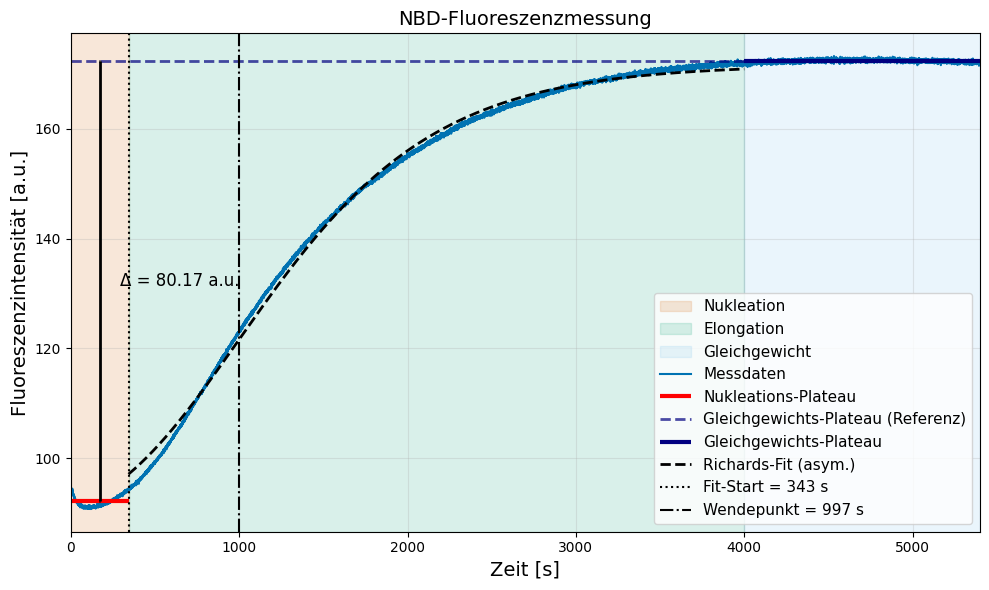

Richards-Fit (asymmetrisch):
K  = 84.124 a.u.
r  = 1.5533e-03 1/s
t0 = 0.0 s
nu = 4.704
Wendepunkt (max dI/dt) = 996.9 s
Steigung dort = 0.0435 a.u./s = 2.61 a.u./min


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -----------------------------
# Annahmen: x, y existieren schon (numpy arrays)
# -----------------------------
x = np.asarray(x)
y = np.asarray(y)

# Phasen-Grenzen
tN0, tN1 = 0, 343
tE0, tE1 = 343, 4000
tG0, tG1 = 4000, 5400

# -----------------------------
# Plateaus (wie bisher)
# -----------------------------
mask_nuc = (x >= tN0) & (x <= tN1)
mask_eq  = (x >= tG0) & (x <= min(tG1, x.max()))

nuc_mean = float(np.mean(y[mask_nuc]))
eq_mean  = float(np.mean(y[mask_eq]))
delta_plateau = eq_mean - nuc_mean

# "Start" für den Fit am niedrigsten Wert der Nukleation
nuc_min = float(np.min(y[mask_nuc]))

# -----------------------------
# Option C: datengetriebener Fit-Start über Steigung (nur zur Fenstersuche geglättet)
# -----------------------------
smooth_window = 51      # ungerade Zahl
slope_fraction = 0.10   # 10% von max(dy/dt)

w = smooth_window
kernel = np.ones(w) / w
y_smooth = np.convolve(y, kernel, mode="same")
dy = np.gradient(y_smooth, x)

thr = slope_fraction * np.max(dy)
idx0 = int(np.argmax(dy > thr))          # erster Punkt über Schwelle
t_start = float(max(x[idx0], tE0))       # nicht vor Ende Nukleation starten
t_end = float(min(tE1, x.max()))

mask_fit = (x >= t_start) & (x <= t_end)
x_fit = x[mask_fit]
y_fitdata = y[mask_fit]

# -----------------------------
# Asymmetrischer Sigmoid: Richards (mit Start bei nuc_min garantiert via Offset bei t=0)
#   y(t) = nuc_min + K * ( S(t)^nu - S(0)^nu )
#   S(t) = 1/(1+exp(-r(t-t0)))
# -----------------------------
def richards_y0min(t, K, r, t0, nu):
    S  = 1.0 / (1.0 + np.exp(-r * (t - t0)))
    S0 = 1.0 / (1.0 + np.exp(-r * (0.0 - t0)))
    return nuc_min + K * (S**nu - S0**nu)

# Startwerte
K0   = max(eq_mean - nuc_min, 1e-6)
r0   = 0.002
t0_0 = 1200.0
nu0  = 2.0
p0 = [K0, r0, t0_0, nu0]

# Bounds
bounds_lower = [0.0,   0.0,   0.0,  0.5]
bounds_upper = [np.inf, 1.0,  x.max(), 8.0]

params, cov = curve_fit(
    richards_y0min, x_fit, y_fitdata,
    p0=p0,
    bounds=(bounds_lower, bounds_upper),
    maxfev=300000
)

K_r, r_r, t0_r, nu_r = params
y_rich = richards_y0min(x, *params)

# Wendepunkt/Max-Steigung robust aus Ableitung der Fitkurve im Elongationsfenster
t_grid = np.linspace(0, x.max(), 20000)
y_grid = richards_y0min(t_grid, *params)
dy_dt = np.gradient(y_grid, t_grid)

mask_inf = (t_grid >= tE0) & (t_grid <= t_end)
i_max = int(np.argmax(dy_dt[mask_inf]))
t_inf = float(t_grid[mask_inf][i_max])
slope_sec = float(dy_dt[mask_inf][i_max])
slope_min = slope_sec * 60.0

# -----------------------------
# Plot (alles zusammen)
# -----------------------------
plt.figure(figsize=(10, 6))

# Phasen
plt.axvspan(tN0, tN1, color="#D55E00", alpha=0.15, label="Nukleation")
plt.axvspan(tE0, tE1, color="#009E73", alpha=0.15, label="Elongation")
plt.axvspan(tG0, tG1, color="#56B4E9", alpha=0.12, label="Gleichgewicht")

# Daten
plt.plot(x, y, color="#0072B2", label="Messdaten")

# Plateaus
plt.hlines(nuc_mean, xmin=tN0, xmax=tN1, colors="red", linewidth=3, label="Nukleations-Plateau")

# Gleichgewicht: Referenz gestrichelt bis t=0 + durchgezogen im Gleichgewichtsfenster
plt.hlines(eq_mean, xmin=0, xmax=x.max(), colors="navy", linestyles="--", linewidth=2, alpha=0.7, label="Gleichgewichts-Plateau (Referenz)")
plt.hlines(eq_mean, xmin=tG0, xmax=x.max(), colors="navy", linewidth=3, label="Gleichgewichts-Plateau")

# Δ-Klammer mittig im Nukleationsfenster + Text etwas weg
x_bracket = 0.5 * (tN0 + tN1)
plt.vlines(x_bracket, nuc_mean, eq_mean, colors="k", linewidth=2)
plt.hlines([nuc_mean, eq_mean], x_bracket*0.98, x_bracket*1.02, colors="k", linewidth=2)
plt.text(x_bracket + 120, 0.5*(nuc_mean+eq_mean), f"Δ = {delta_plateau:.2f} a.u.", va="center", fontsize=12)

# Richards-Fit nur im Fit-Fenster zeichnen (optisch fair)
plt.plot(x_fit, richards_y0min(x_fit, *params), "k--", linewidth=2, label="Richards-Fit (asym.)")

# Fit-Start + Wendepunkt (max dI/dt)
plt.axvline(t_start, color="k", linestyle=":", linewidth=1.5, label=f"Fit-Start = {t_start:.0f} s")
plt.axvline(t_inf, color="k", linestyle="-.", linewidth=1.5, label=f"Wendepunkt = {t_inf:.0f} s")

plt.xlim(0, x.max())
plt.title("NBD-Fluoreszenzmessung", fontsize=14)
plt.xlabel("Zeit [s]", fontsize=14)
plt.ylabel("Fluoreszenzintensität [a.u.]", fontsize=14)

plt.legend(loc="lower right", fontsize=11, frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Richards-Fit (asymmetrisch):")
print(f"K  = {K_r:.3f} a.u.")
print(f"r  = {r_r:.4e} 1/s")
print(f"t0 = {t0_r:.1f} s")
print(f"nu = {nu_r:.3f}")
print(f"Wendepunkt (max dI/dt) = {t_inf:.1f} s")
print(f"Steigung dort = {slope_sec:.4f} a.u./s = {slope_min:.2f} a.u./min")


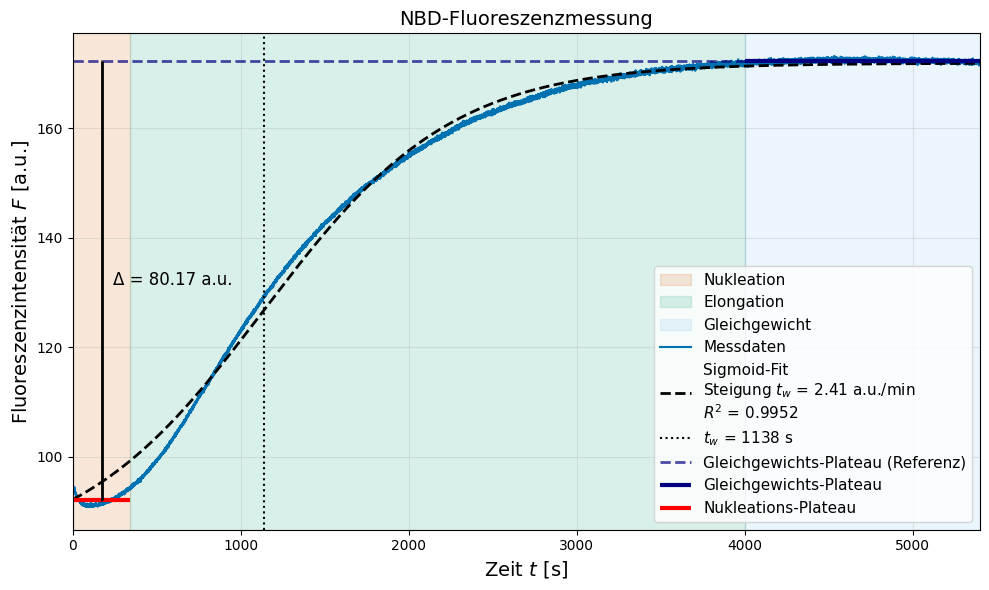

Sigmoid-Fit:
Wendepunkt t_w = 1137.8 s
Steigung       = 2.413 a.u./min
R²             = 0.99516


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# -----------------------------
# Sigmoid mit y(0)=nuc_mean garantiert
# -----------------------------
def sigmoid_y0(t, K, r, t0):
    S  = 1 / (1 + np.exp(-r * (t - t0)))
    S0 = 1 / (1 + np.exp(-r * (0 - t0)))
    return nuc_mean + K * (S - S0)

# -----------------------------
# Fit-Fenster
# -----------------------------
t_low, t_high = 200, x.max()
mask_fit = (x >= t_low) & (x <= t_high)
x_fit = x[mask_fit]
y_fitdata = y[mask_fit]

# -----------------------------
# Startwerte + Bounds
# -----------------------------
K0   = eq_mean - nuc_mean
r0   = 0.002
t0_0 = 1200.0
p0 = [K0, r0, t0_0]

bounds_lower = [0.0, 0.0, 0.0]
bounds_upper = [np.inf, 1.0, x.max()]

# -----------------------------
# Fit
# -----------------------------
params, cov = curve_fit(
    sigmoid_y0, x_fit, y_fitdata,
    p0=p0,
    bounds=(bounds_lower, bounds_upper),
    maxfev=200000
)

K_s, r_s, t0_s = params
y_sig = sigmoid_y0(x, *params)

# -----------------------------
# Wendepunkt & Steigung am Wendepunkt
# -----------------------------
t_w = t0_s
steigung_sec = (K_s * r_s) / 4.0
steigung_min = steigung_sec * 60.0

# -----------------------------
# R² im Fit-Fenster
# -----------------------------
y_fit_model = sigmoid_y0(x_fit, *params)

ss_res = np.sum((y_fitdata - y_fit_model)**2)
ss_tot = np.sum((y_fitdata - np.mean(y_fitdata))**2)
r_squared = 1 - ss_res / ss_tot

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10, 6))

# Phasen
plt.axvspan(0, 343, color="#D55E00", alpha=0.15, label="Nukleation")
plt.axvspan(343, 4000, color="#009E73", alpha=0.15, label="Elongation")
plt.axvspan(4000, 5400, color="#56B4E9", alpha=0.12, label="Gleichgewicht")

# Messdaten
plt.plot(x, y, color="#0072B2", label="Messdaten")

# Sigmoid-Fit mit Kenngrößen
mask_plot = x >= 0
plt.plot(
    x[mask_plot], y_sig[mask_plot],
    "k--", linewidth=2,
    label=(
        "Sigmoid-Fit\n"
        # f"Wendepunkt $t_w$ = {t_w:.0f} s\n"
        f"Steigung $t_w$ = {steigung_min:.2f} a.u./min\n"
        f"$R^2$ = {r_squared:.4f}"
    )
)

# Wendepunkt-Linie
plt.axvline(t_w, color="k", linestyle=":", linewidth=1.5, label=f"$t_w$ = {t_w:.0f} s")

# Gleichgewichts-Plateau: gestrichelt über ganzen Plot (Referenz)
plt.hlines(
    eq_mean,
    xmin=0, xmax=x.max(),
    colors="navy",
    linestyles="--",
    linewidth=2,
    alpha=0.7,
    label="Gleichgewichts-Plateau (Referenz)"
)

# Gleichgewichts-Plateau: durchgezogen im Bereich
plt.hlines(
    eq_mean,
    xmin=4000, xmax=x.max(),
    colors="navy",
    linewidth=3,
    label="Gleichgewichts-Plateau"
)

# Nukleations-Plateau
plt.hlines(
    nuc_mean,
    xmin=0, xmax=343,
    colors="red",
    linewidth=3,
    label="Nukleations-Plateau"
)

# Delta-Klammer
x_bracket = 0.5 * (0 + 343)
plt.vlines(x_bracket, nuc_mean, eq_mean, colors="k", linewidth=2)
plt.hlines([nuc_mean, eq_mean], x_bracket*0.98, x_bracket*1.02, colors="k", linewidth=2)

# Delta-Text
plt.text(
    x_bracket + 70,
    0.5 * (nuc_mean + eq_mean),
    f"Δ = {delta_plateau:.2f} a.u.",
    va="center",
    fontsize=12
)

# Achsen
plt.xlim(0, x.max())
plt.title("NBD-Fluoreszenzmessung", fontsize=14)
plt.xlabel(f"Zeit $t$ [s]", fontsize=14)
plt.ylabel(f"Fluoreszenzintensität $F$ [a.u.]", fontsize=14)

plt.legend(loc="lower right", fontsize=11, frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# Konsolen-Ausgabe
# -----------------------------
print("Sigmoid-Fit:")
print(f"Wendepunkt t_w = {t_w:.1f} s")
print(f"Steigung       = {steigung_min:.3f} a.u./min")
print(f"R²             = {r_squared:.5f}")
